In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import cell2location
import scvi
from scipy.io import mmread
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0


In [2]:
results_folder = '../results/analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures_liver'
run_name = f'{results_folder}/cell2location_map_liver'

In [3]:
slide_name='HCC-1N'
adata_file = f"{run_name}/{slide_name}.h5ad"
adata_vis = sc.read_h5ad(adata_file)
# mod = cell2location.models.Cell2location.load(f"{new_run_name}", adata_vis)

In [4]:
adata_vis

AnnData object with n_obs × n_vars = 2956 × 16365
    obs: 'in_tissue', 'array_row', 'array_col', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [5]:
adata_vis.obsm['q05_cell_abundance_w_sf']

q05cell_abundance_w_sf_ASC  q05cell_abundance_w_sf_B  \
AAACAAGTATCTCCCA-1                    0.013376                  0.150135   
AAACAGAGCGACTCCT-1                    0.374986                  0.150576   
AAACAGTGTTCCTGGG-1                    0.002795                  0.086351   
AAACATTTCCCGGATT-1                    0.004566                  0.048883   
AAACCGGGTAGGTACC-1                    0.031858                  0.247721   
...                                        ...                       ...   
TTGTTGTGTGTCAAGA-1                    0.021658                  0.060230   
TTGTTTCACATCCAGG-1                    0.064432                  0.161804   
TTGTTTCATTAGTCTA-1                    0.014554                  0.049836   
TTGTTTCCATACAACT-1                    0.024303                  0.289533   
TTGTTTGTATTACACG-1                    0.001491                  0.059089   

                    q05cell_abundance_w_sf_CD4+ T  \
AAACAAGTATCTCCCA-1                       0.204966   
AAACAGAGCGACTCCT-1                       0.221670   
AAACAGTGTTCCTGGG-1                       0.110122   
AAACATTTCCCGGATT-1                       0.074265   
AAACCGGGTAGGTACC-1                       0.470365   
...                                           ...   
TTGTTGTGTGTCAAGA-1                       0.078135   
TTGTTTCACATCCAGG-1                       0.220425   
TTGTTTCATTAGTCTA-1                       0.030337   
TTGTTTCCATACAACT-1                       0.368427   
TTGTTTGTATTACACG-1                       0.156058   

                    q05cell_abundance_w_sf_CD8+ T  \
AAACAAGTATCTCCCA-1                       0.138255   
AAACAGAGCGACTCCT-1                       0.161938   
AAACAGTGTTCCTGGG-1                       0.067649   
AAACATTTCCCGGATT-1                       0.094346   
AAACCGGGTAGGTACC-1                       0.313353   
...                                           ...   
TTGTTGTGTGTCAAGA-1                       0.061946   
TTGTTTCACATCCAGG-1                       0.167691   
TTGTTTCATTAGTCTA-1                       0.057162   
TTGTTTCCATACAACT-1                       0.285366   
TTGTTTGTATTACACG-1                       0.097669   

                    q05cell_abundance_w_sf_Dendritic  \
AAACAAGTATCTCCCA-1                          0.044309   
AAACAGAGCGACTCCT-1                          0.270149   
AAACAGTGTTCCTGGG-1                          0.028561   
AAACATTTCCCGGATT-1                          0.050647   
AAACCGGGTAGGTACC-1                          0.171961   
...                                              ...   
TTGTTGTGTGTCAAGA-1                          0.110672   
TTGTTTCACATCCAGG-1                          0.121901   
TTGTTTCATTAGTCTA-1                          0.228926   
TTGTTTCCATACAACT-1                          0.132038   
TTGTTTGTATTACACG-1                          0.073954   

                    q05cell_abundance_w_sf_Endothelial  \
AAACAAGTATCTCCCA-1                            0.668108   
AAACAGAGCGACTCCT-1                            1.008027   
AAACAGTGTTCCTGGG-1                            0.136236   
AAACATTTCCCGGATT-1                            0.715355   
AAACCGGGTAGGTACC-1                            0.674960   
...                                                ...   
TTGTTGTGTGTCAAGA-1                            0.734749   
TTGTTTCACATCCAGG-1                            0.758636   
TTGTTTCATTAGTCTA-1                            0.827360   
TTGTTTCCATACAACT-1                            1.205864   
TTGTTTGTATTACACG-1                            0.495031   

                    q05cell_abundance_w_sf_Epithelial  \
AAACAAGTATCTCCCA-1                          12.607351   
AAACAGAGCGACTCCT-1                          10.379274   
AAACAGTGTTCCTGGG-1                           5.940182   
AAACATTTCCCGGATT-1                           7.321079   
AAACCGGGTAGGTACC-1                           7.707090   
...                                               ...   
TTGTTGTGTGTCAAGA-1                           4.788180   
TTGTTTC

In [6]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=0.2)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

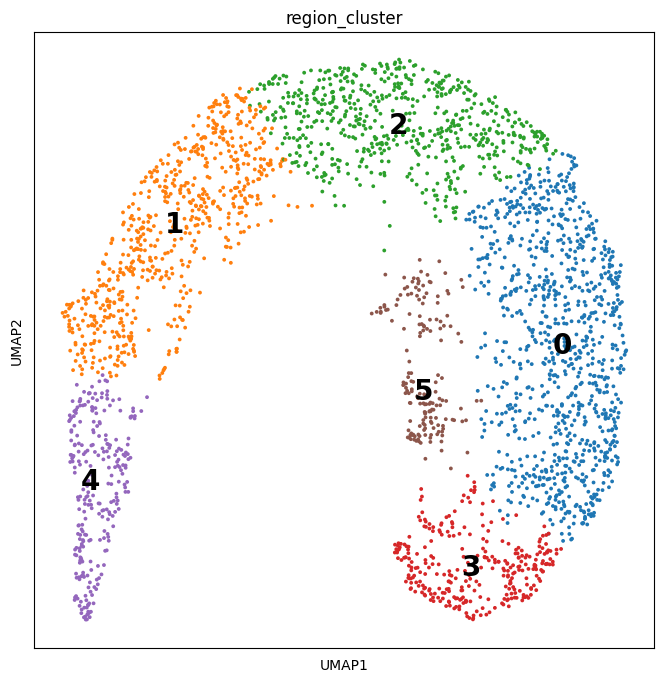

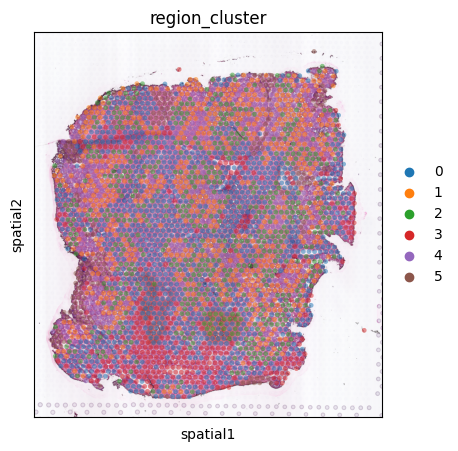

In [7]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
#     sc.pl.umap(adata_vis, color=['sample'], size=30,
#                color_map = 'RdPu', ncols = 2,
#                legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'], 
                  size=1.3, img_key='hires', alpha=0.5)

In [8]:
adata_vis.obs["region_cluster"]

AAACAAGTATCTCCCA-1    1
AAACAGAGCGACTCCT-1    1
AAACAGTGTTCCTGGG-1    0
AAACATTTCCCGGATT-1    2
AAACCGGGTAGGTACC-1    5
                     ..
TTGTTGTGTGTCAAGA-1    3
TTGTTTCACATCCAGG-1    1
TTGTTTCATTAGTCTA-1    4
TTGTTTCCATACAACT-1    4
TTGTTTGTATTACACG-1    3
Name: region_cluster, Length: 2956, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [9]:
name=list(adata_vis.uns['spatial'].keys())[0]

In [10]:
adata_vis

AnnData object with n_obs × n_vars = 2956 × 16365
    obs: 'in_tissue', 'array_row', 'array_col', '_indices', '_scvi_batch', '_scvi_labels', 'leiden', 'region_cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial', 'neighbors', 'leiden', 'umap', 'region_cluster_colors'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf', 'X_umap'
    obsp: 'distances', 'connectivities'

In [11]:
adata_vis.obs['sample']=name

In [12]:
types=['ASC',
 'B',
 'CD4+ T',
 'CD8+ T',
 'Dendritic',
 'Endothelial',
 'Epithelial',
 'Fibroblast',
 'ILC',
 'MAIT',
 'MZB',
 'Macrophage',
 'Mast',
 'Mature B',
 'Memory B',
 'Mono',
 'NK',
 'NKT',
 'Naive B',
 'Plasma B',
 'Treg']

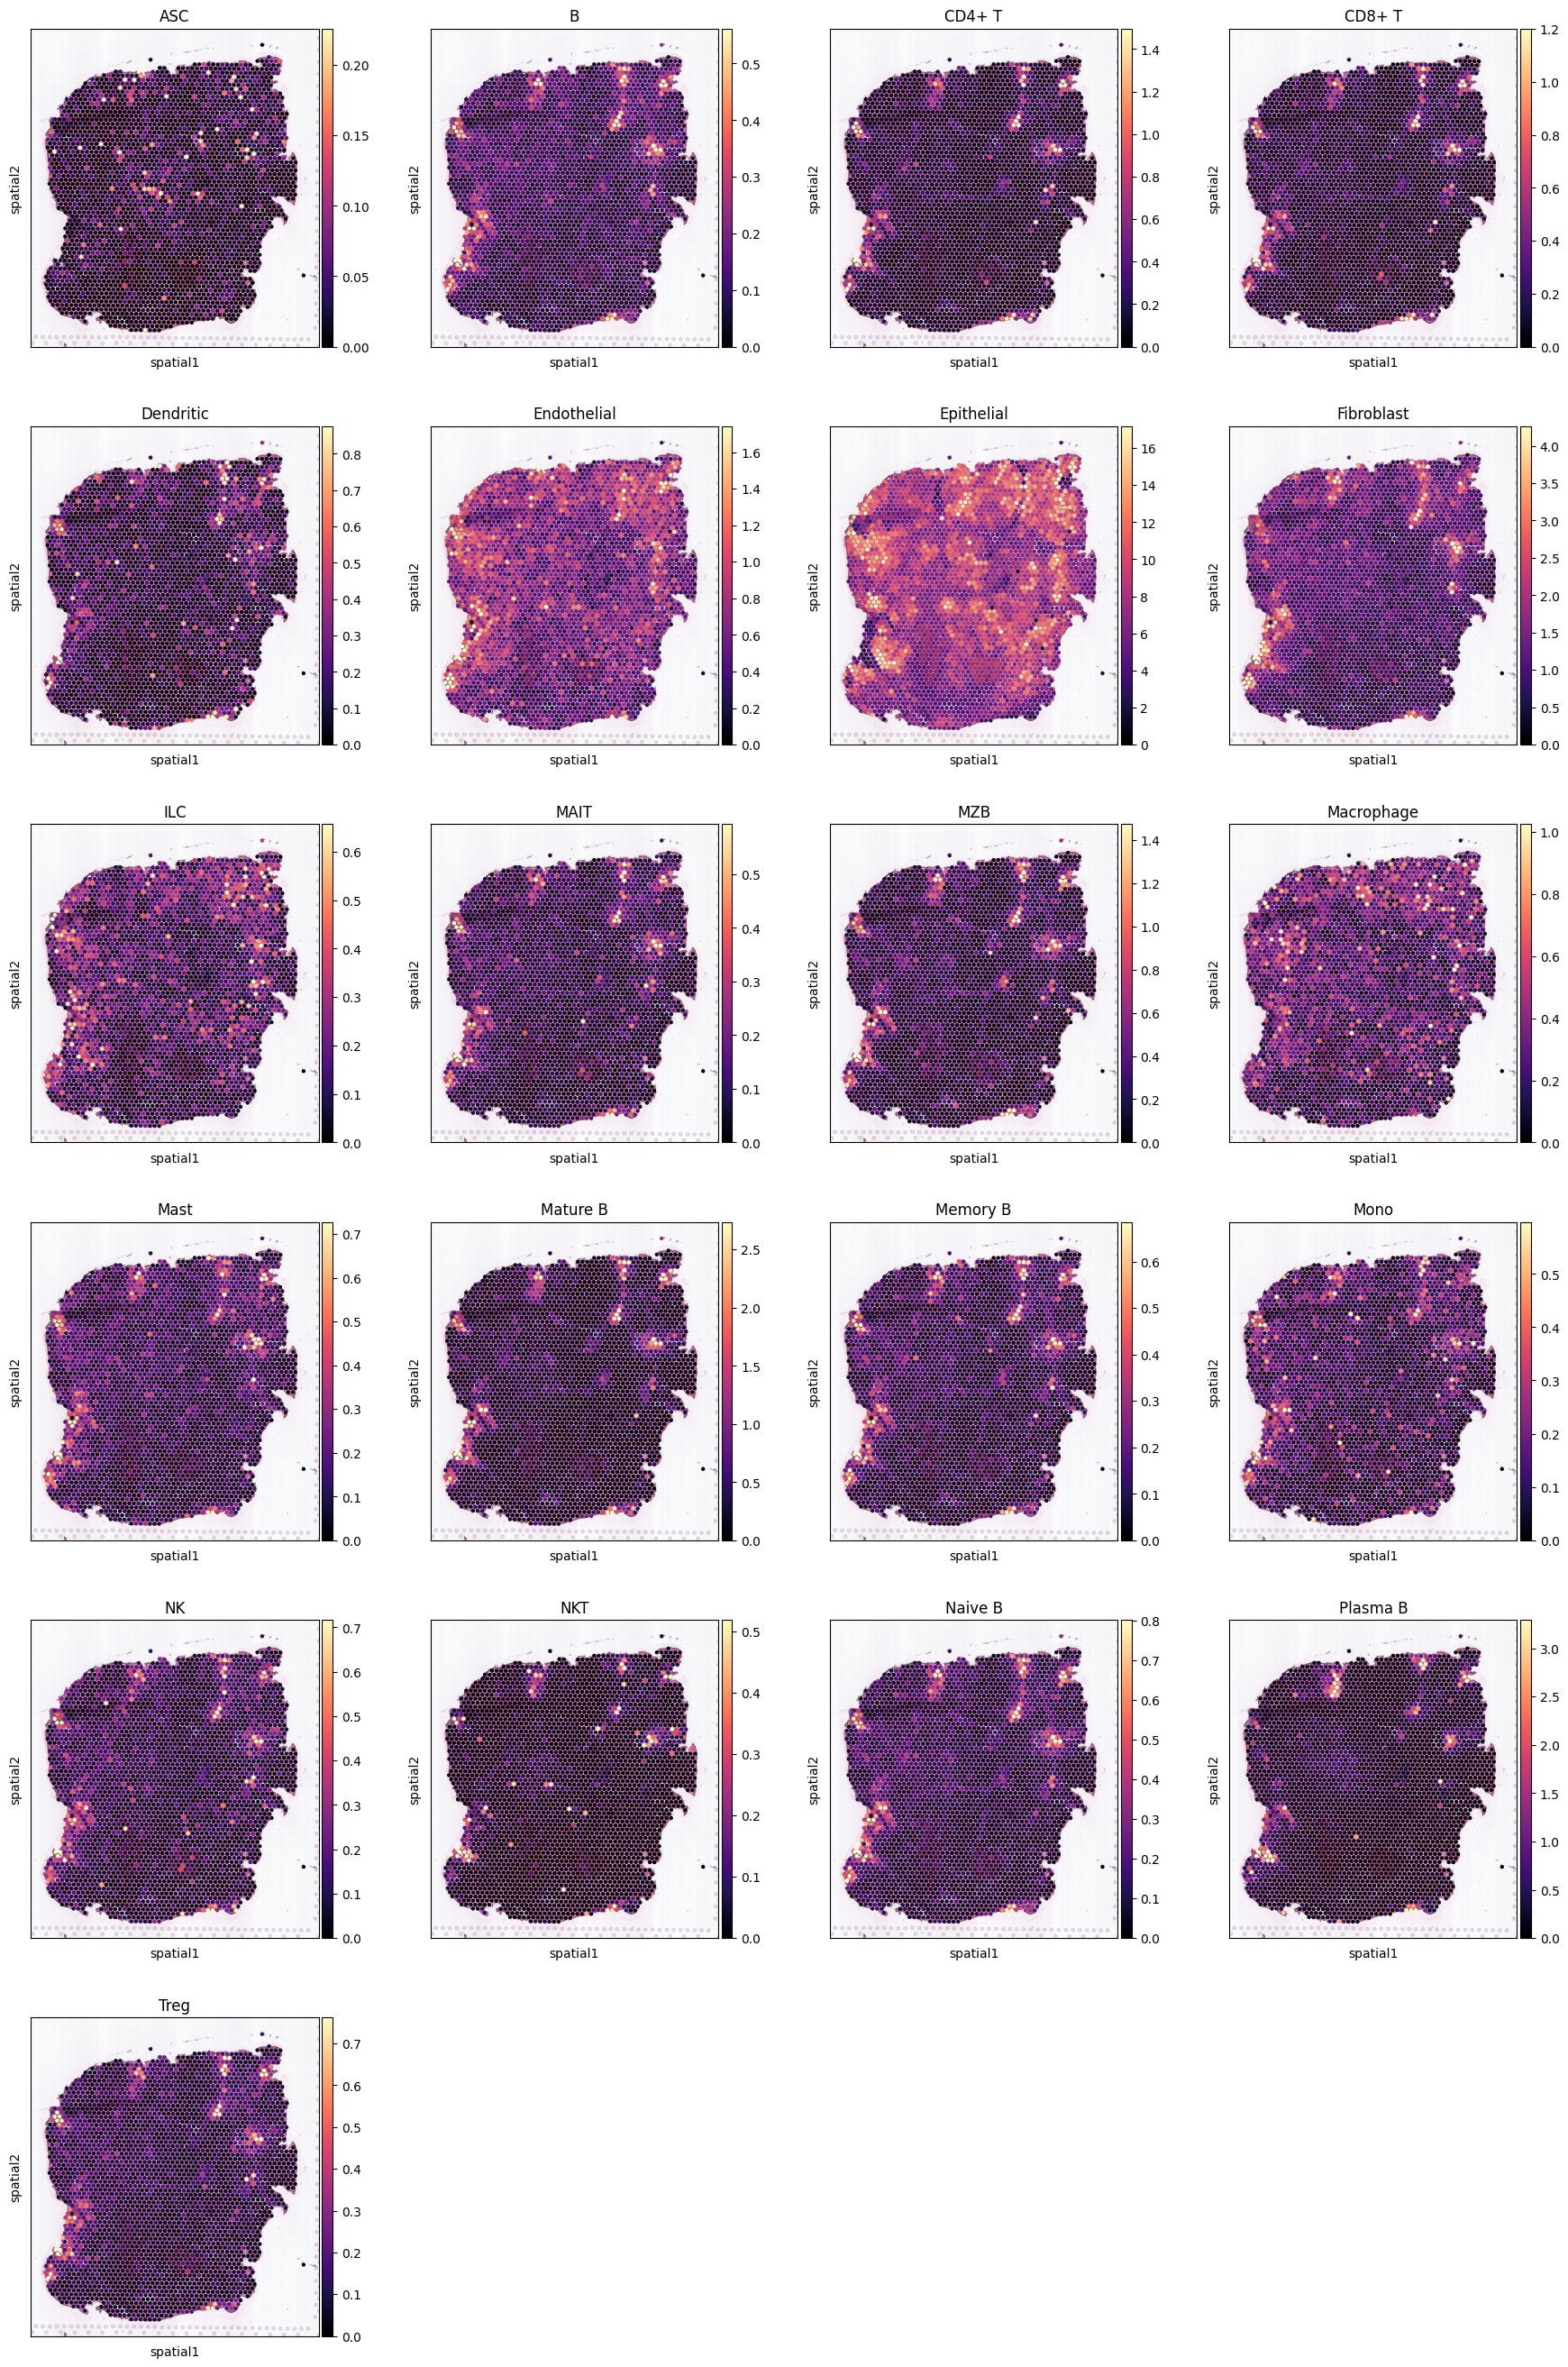

In [13]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, name)
    
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    
    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=types, 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  save=f'cell2loc_{slide_name}.png'
                 )
plt.show()

# Cells of each cluster

In [30]:
spot2cell_q05_class0=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='0')]
spot2cell_q05_class1=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='1')]
spot2cell_q05_class2=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='2')]
spot2cell_q05_class3=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='3')]
spot2cell_q05_class4=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='4')]
spot2cell_q05_class5=adata_vis.obsm['q05_cell_abundance_w_sf'][np.array(adata_vis.obs["region_cluster"]=='5')]
spot2cell=[spot2cell_q05_class0,spot2cell_q05_class1,spot2cell_q05_class2,spot2cell_q05_class3,spot2cell_q05_class4,spot2cell_q05_class5]

In [31]:
spot2cell_q05_class0.columns

Index(['q05cell_abundance_w_sf_ASC', 'q05cell_abundance_w_sf_B',
       'q05cell_abundance_w_sf_CD4+ T', 'q05cell_abundance_w_sf_CD8+ T',
       'q05cell_abundance_w_sf_Dendritic',
       'q05cell_abundance_w_sf_Endothelial',
       'q05cell_abundance_w_sf_Epithelial',
       'q05cell_abundance_w_sf_Fibroblast', 'q05cell_abundance_w_sf_ILC',
       'q05cell_abundance_w_sf_MAIT', 'q05cell_abundance_w_sf_MZB',
       'q05cell_abundance_w_sf_Macrophage', 'q05cell_abundance_w_sf_Mast',
       'q05cell_abundance_w_sf_Mature B', 'q05cell_abundance_w_sf_Memory B',
       'q05cell_abundance_w_sf_Mono', 'q05cell_abundance_w_sf_NK',
       'q05cell_abundance_w_sf_NKT', 'q05cell_abundance_w_sf_Naive B',
       'q05cell_abundance_w_sf_Plasma B', 'q05cell_abundance_w_sf_Treg'],
      dtype='object')

In [32]:
spot2cell_q05_class0.columns=types
spot2cell_q05_class1.columns=types
spot2cell_q05_class2.columns=types
spot2cell_q05_class3.columns=types
spot2cell_q05_class4.columns=types
spot2cell_q05_class5.columns=types

In [33]:
spot2cell_q05_class0.columns

Index(['ASC', 'B', 'CD4+ T', 'CD8+ T', 'Dendritic', 'Endothelial',
       'Epithelial', 'Fibroblast', 'ILC', 'MAIT', 'MZB', 'Macrophage', 'Mast',
       'Mature B', 'Memory B', 'Mono', 'NK', 'NKT', 'Naive B', 'Plasma B',
       'Treg'],
      dtype='object')

In [34]:
# for i in range(4):
#     spot2cell[i].to_csv('spot2cell_q05_class_4_'+str(i)+'.csv')

In [40]:
npclass0=np.array(spot2cell_q05_class0)
npclass1=np.array(spot2cell_q05_class1)
npclass2=np.array(spot2cell_q05_class2)
npclass3=np.array(spot2cell_q05_class3)
npclass4=np.array(spot2cell_q05_class4)
npclass5=np.array(spot2cell_q05_class5)

In [38]:
np.arange(0,21)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [42]:
npmean0=np.mean(npclass0,axis=0)
npmean1=np.mean(npclass1,axis=0)
npmean2=np.mean(npclass2,axis=0)
npmean3=np.mean(npclass3,axis=0)

In [45]:
npmean0

array([0.31433808, 0.04904057, 0.05243098, 0.06836304, 0.09184759,
       0.45860532, 4.75602076, 1.07822231, 0.07349776, 0.04911965,
       0.42741002, 0.16164158, 0.06752038, 1.99980843, 0.1154691 ,
       0.09416923, 0.03833186, 0.36155648, 0.05183443, 0.16839624,
       0.0599334 ])

In [47]:
x=np.arange(0,21)
cells=[[],[],[],[]]
fig = plt.figure(figsize=(8,6), dpi=140)
ax1 = plt.subplot(2, 2, 1)
ax1.plot(x,npmean0,'o',markersize=3)
ax2 = plt.subplot(2, 2, 2)
ax2.plot(x,npmean1,'o',markersize=3)
ax3 = plt.subplot(2, 2, 3)
ax3.plot(x,npmean2,'o',markersize=3)
ax4 = plt.subplot(2, 2, 4)
ax4.plot(x,npmean3,'o',markersize=3)
for i in range(len(npmean0)):
    if npmean0[i]>=0.1:
        ax1.text(i,npmean0[i],types[i],size=5)
        cells[0].append(type[i])
for i in range(len(npmean0)):
    if npmean1[i]>=0.1:
        ax2.text(i,npmean1[i],types[i],size=5)
        cells[1].append(type[i])
for i in range(len(npmean0)):
    if npmean2[i]>=0.1:
        ax3.text(i,npmean2[i],types[i],size=5)
        cells[2].append(type[i])
for i in range(len(npmean0)):
    if npmean3[i]>=0.1:
        ax4.text(i,npmean3[i],types[i],size=5)
        cells[3].append(type[i])
